## Harmonize NDVI Time Series

In [2]:
# import libraries
import os
import glob
import pathlib
import xarray as xr
import geopandas as gpd
import odc.stac
import rasterio
import pandas as pd
import warnings
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

In [3]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [4]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# Prepare overlapping AVHRR time series: 2000 - 2010

In [5]:
# load NDVI dataset of one day as example
ndvi_ex = xr.open_dataset("./Raw/NDVI_AVHRR/2000/AVHRR-Land_v005_AVH13C1_NOAA-14_20000101_c20170623095628.nc", 
                     decode_coords="all", 
                     decode_times=True)

In [6]:
# define crs
ndvi_ex.rio.write_crs(4326, inplace=True)

<xarray.Dataset> Size: 584kB
Dimensions:    (time: 1, latitude: 165, longitude: 196)
Coordinates:
  * time       (time) datetime64[ns] 8B 2000-01-01
  * latitude   (latitude) float32 660B 55.17 55.12 55.07 ... 47.07 47.02 46.97
  * longitude  (longitude) float32 784B 5.425 5.475 5.525 ... 15.07 15.12 15.18
    crs        int64 8B 0
Data variables:
    NDVI       (time, latitude, longitude) float64 259kB ...
    QA         (time, latitude, longitude) int16 65kB ...
    TIMEOFDAY  (time, latitude, longitude) datetime64[ns] 259kB ...
Attributes: (12/49)
    title:                                  Normalized Difference Vegetation ...
    institution:                            NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-...
    Conventions:                            CF-1.6, ACDD-1.3
    standard_name_vocabulary:               CF Standard Name Table (v25, 05 J...
    naming_authority:                       gov.noaa.ncei
    license:                                See the Use Agreement for this CD...
    ...                                     ...
    PercentValidDaytimeLand:                32.03
    PercentValidClearDaytimeLand:           3.94
    PercentValidDaytimeLandInCloudShadow:   1.19
    PercentValidClearDaytimeWater:          0.00
    PercentValidDaytimeWaterInCloudShadow:  0.00
    History:                                Translated to CF-1.0 Conventions ...

In [7]:
# load Germany shapefile 
ger = gpd.read_file("./GER.shp")

In [8]:
# check if crs matches ndvi data
ger.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# create mask of research area using the dimensions of the exemplary ndvi data
ger_mask = rasterio.features.geometry_mask(ger.geometry, 
                                            out_shape=ndvi_ex.odc.geobox.shape,
                                            transform=ndvi_ex.odc.geobox.affine,
                                            all_touched=False,
                                            invert=False)

In [10]:
ger_mask = xr.DataArray(ger_mask, dims=("latitude", "longitude"))

In [11]:
# create loop to process all datasets
for year in range(2000, 2011):

    # open daily netCDF datasets of corresponding year
    directory = f"./Raw/NDVI_AVHRR/{year}"
    files = list(pathlib.Path(directory).glob('*.nc'))

    for f in range(len(files)):
        file = files[f]
        
        ndvi = xr.open_dataset(file, decode_coords = "all", decode_times = True)

        # define crs
        ndvi.rio.write_crs(4326, inplace = True)

        # apply mask of research area to ndvi dataset 
        ndvi_ger = ndvi.where(~ger_mask)
        
        # extract quality flag pixel values as dataframe
        df_qa_pixelvalues = ndvi_ger.QA.to_dataframe()

        # count frequency of pixel values and extract to dataframe
        df_qa_freq = df_qa_pixelvalues["QA"].value_counts().to_frame()

        # create new column with quality flag
        df_qa_freq["qa_flag"] = df_qa_freq.index

        # reset index
        df_qa_freq.reset_index(drop = True, inplace = True)

        # rename column with counts
        df_qa_freq.rename({'count':'qa_flag_freq'},axis=1, inplace= True)

        # convert values to integer
        df_qa_freq["qa_flag"] = df_qa_freq["qa_flag"].astype("int16")

        # convert quality flags to binary to assess quality information stored in bits
        # define function to convert decimal numbers to signed 16bit
        def to_signed_16bit(n):
            # make sure value is an integer
            n = int(n)
            if n < 0:
            # apply 2's complement for negative numbers
                n = (1 << 16) + n
            # convert to 16-bit binary string
            return f'{n:016b}'
        
        # apply function to quality flag column 
        df_qa_freq["binary"] = df_qa_freq["qa_flag"].apply(to_signed_16bit)

        # create new columns with the different quality information stored in the bits to assess them seperately
        # source: https://www.ncei.noaa.gov/pub/data/sds/cdr/CDRs/Normalized_Difference_Vegetation_Index/AVHRR/AlgorithmDescriptionAVHRR_01B-20b.pdf
        df_qa_freq['Polar'] = df_qa_freq['binary'].astype(str).str[0]
        df_qa_freq['BRDF-correction issues'] = df_qa_freq['binary'].astype(str).str[1]
        df_qa_freq['RHO3 invalid'] = df_qa_freq['binary'].astype(str).str[2]
        df_qa_freq['Channel 5 invalid'] = df_qa_freq['binary'].astype(str).str[3]
        df_qa_freq['Channel 4 invalid'] = df_qa_freq['binary'].astype(str).str[4]
        df_qa_freq['Channel 3 invalid'] = df_qa_freq['binary'].astype(str).str[5]
        df_qa_freq['Channel 2 invalid'] = df_qa_freq['binary'].astype(str).str[6]
        df_qa_freq['Channel 1 invalid'] = df_qa_freq['binary'].astype(str).str[7]
        df_qa_freq['Channels 1-5 valid'] = df_qa_freq['binary'].astype(str).str[8]
        df_qa_freq['Night'] = df_qa_freq['binary'].astype(str).str[9]
        df_qa_freq['Dense dark vegetation'] = df_qa_freq['binary'].astype(str).str[10]
        df_qa_freq['Sunglint'] = df_qa_freq['binary'].astype(str).str[11]
        df_qa_freq['Water'] = df_qa_freq['binary'].astype(str).str[12]
        df_qa_freq['Cloud Shadow'] = df_qa_freq['binary'].astype(str).str[13]
        df_qa_freq['Cloudy'] = df_qa_freq['binary'].astype(str).str[14]
        df_qa_freq['Unused'] = df_qa_freq['binary'].astype(str).str[15]
        
        # extract all quality flag values that are fit for our purpose and should be kept in the dataset
        df_qa_tokeep = df_qa_freq[(df_qa_freq['Cloudy']=="0") & 
                                (df_qa_freq['Channel 1 invalid']=="0") & 
                                (df_qa_freq["Channel 2 invalid"]=="0") &
                                (df_qa_freq["Night"]=="0") &
                                (df_qa_freq["Sunglint"]=="0")]
        
        qa_tokeep = df_qa_tokeep["qa_flag"]

        # create a mask for the ndvi datasets that only keeps pixels of good quality
        mask = ndvi_ger["QA"].isin(qa_tokeep).compute()

        # mask dataset
        ndvi_masked = ndvi_ger["NDVI"].where(mask, drop = False)

        # load forest area from ESA Landcover data for corresponding year
        forest_year = year
        
        forest = xr.open_dataset(f"./Forest_GER/Forest_GER_{forest_year}.nc", 
                                decode_coords = "all", 
                                decode_times= True)

        # set crs for ndvi data
        ndvi_masked.rio.write_crs(4326, inplace = True)

        # rename dimensions to match forest dataset
        ndvi_masked = ndvi_masked.rename({'latitude':'lat', 'longitude':'lon'})

        # resample ndvi dataset to match resolution of forest dataset
        ndvi_match = ndvi_masked.rio.reproject_match(forest)

        # rename dimensions again - they got renamed while resampling
        ndvi_match = ndvi_match.rename({'y':'lat', 'x':'lon'})

        # mask ndvi with forest data
        # broadleaved forest:
        ndvi_BL = ndvi_match.where(forest.lccs_class.sel(time=f"{forest_year}-01-01") == 60, 
                                drop = False)

        # needleleaved forest:
        NL_mask = forest.lccs_class.sel(time=f"{forest_year}-01-01").isin([70, 80]).compute()
        ndvi_NL = ndvi_match.where(NL_mask, drop = False)

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        ndvi_BL.encoding.update(comp)
        ndvi_NL.encoding.update(comp)
        
        # save as netCDF4 datasets
        date = ndvi_match.coords["time"].dt.strftime('%Y-%m-%d').values[0]
        ndvi_BL.to_netcdf(f"./NDVI/Daily/{year}/NDVI_{date}_BL.nc")
        ndvi_NL.to_netcdf(f"./NDVI/Daily/{year}/NDVI_{date}_NL.nc")

    # print status
    print(f"Files for year {year} processed.")

Files for year 2000 processed.
Files for year 2001 processed.
Files for year 2002 processed.
Files for year 2003 processed.
Files for year 2004 processed.
Files for year 2005 processed.
Files for year 2006 processed.
Files for year 2007 processed.
Files for year 2008 processed.
Files for year 2009 processed.
Files for year 2010 processed.


In [12]:
# Calculate Monthly and Yearly values for 2000 - 2010 AVHRR

In [13]:
# create list with forest types
forest_types = ("NL", "BL")

In [14]:
# loop over years to calculate monthly and yearly mean ndvi values per pixel

for year in range(2000, 2011):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get all files of according year that belong to forest type
        directory = f"./NDVI/Daily/{year}"
        filelist = glob.glob(os.path.join(directory, f"*{forest_type}*.nc"))

        # open netCDF dataset of corresponding year with all daily datasets concatenated
        ndvi = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

        # calculate monthly mean values
        ndvi_mon_mean = ndvi.resample(time="1MS", skipna=True).mean("time")

        # calculate yearly mean values
        ndvi_year_mean = ndvi.resample(time="1YS", skipna=True).mean("time")

        # compress data to reduce size
        # in a dataset, encoding for all variables has to be changed explicitly
        comp = dict(zlib=True, complevel=4)
        ndvi_mon_mean.NDVI.encoding.update(comp)
        ndvi_year_mean.NDVI.encoding.update(comp)

        # save created datasets as netCDF4 files
        ndvi_mon_mean.to_netcdf(f"./NDVI/Monthly_AVHRR_Overlap/NDVI_mon_mean_{year}_{forest_type}.nc")
        ndvi_year_mean.to_netcdf(f"./NDVI/Yearly_AVHRR_Overlap/NDVI_year_mean_{year}_{forest_type}.nc")

In [ ]:
# now, calculate linear regressions for different time aggregations and forest types
# load AVHRR and MODIS data for 2000 - 2010 (monthly and yearly, BL and NL)
# start with monthly ndvi of broadleaved forests to show workflow
dir = "./NDVI/Monthly_AVHRR_Overlap"
filelist = glob.glob(os.path.join(dir, "*BL*.nc"))
ndvi_mon_avhrr_BL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

dir = "./NDVI/Monthly"
filelist = []
for year in range(2000, 2011):
    pattern = os.path.join(dir, f'*{year}_BL.nc')
    filelist.extend(glob.glob(pattern))
ndvi_mon_modis_BL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [6]:
ndvi_mon_avhrr_BL

<xarray.Dataset> Size: 11GB
Dimensions:      (time: 132, lat: 2952, lon: 3510)
Coordinates:
    crs          int64 8B 0
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 1kB 2000-01-01 2000-02-01 ... 2010-12-01
Data variables:
    NDVI         (time, lat, lon) float64 11GB dask.array<chunksize=(2, 738, 878), meta=np.ndarray>

In [7]:
ndvi_mon_modis_BL

<xarray.Dataset> Size: 11GB
Dimensions:      (time: 131, lat: 2952, lon: 3510)
Coordinates:
    crs          int8 1B -127
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 1kB 2000-02-01 2000-03-01 ... 2010-12-01
Data variables:
    NDVI         (time, lat, lon) float64 11GB dask.array<chunksize=(2, 738, 878), meta=np.ndarray>

In [8]:
# January 2000 not available in MODIS dataset -> drop this month in AVHRR dataset
date_to_drop = pd.Timestamp("2000-01-01")
ndvi_mon_avhrr_BL = ndvi_mon_avhrr_BL.sel(time=ndvi_mon_avhrr_BL.time != date_to_drop)

In [9]:
ndvi_mon_avhrr_BL

<xarray.Dataset> Size: 11GB
Dimensions:      (time: 131, lat: 2952, lon: 3510)
Coordinates:
    crs          int64 8B 0
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 1kB 2000-02-01 2000-03-01 ... 2010-12-01
Data variables:
    NDVI         (time, lat, lon) float64 11GB dask.array<chunksize=(2, 738, 878), meta=np.ndarray>

In [10]:
# calculate linear regression: Modis = a * AVHRR + b

In [ ]:
# define a function to calculate linear regression between two xarray data arrays
# source: https://stackoverflow.com/questions/52108417/how-to-apply-linear-regression-to-every-pixel-in-a-large-multi-dimensional-array
def xr_regression(x, y, lag_x=0, lag_y=0, dim="time", alternative="two-sided"):
    """
    Source: https://stackoverflow.com/questions/52108417/how-to-apply-linear-regression-to-every-pixel-in-a-large-multi-dimensional-array

    Takes two xr.Datarrays of any dimensions (input data could be a 1D
    time series, or for example, have three dimensions e.g. time, lat,
    lon), and returns covariance, correlation, coefficient of
    determination, regression slope, intercept, p-value and standard
    error, and number of valid observations (n) between the two datasets
    along their aligned first dimension.

    Datasets can be provided in any order, but note that the regression
    slope and intercept will be calculated for y with respect to x.

    Inspired by:
    https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html

    Parameters
    ----------
    x, y : xarray DataArray
        Two xarray DataArrays with any number of dimensions, both
        sharing the same first dimension
    lag_x, lag_y : int, optional
        Optional integers giving lag values to assign to either of the
        data, with lagx shifting x, and lagy shifting y with the
        specified lag amount.
    dim : str, optional
        An optional string giving the name of the dimension on which to
        align (and optionally lag) datasets. The default is 'time'.
    alternative : string, optional
        Defines the alternative hypothesis. Default is 'two-sided'.
        The following options are available:

        * 'two-sided': slope of the regression line is nonzero
        * 'less': slope of the regression line is less than zero
        * 'greater':  slope of the regression line is greater than zero

    Returns
    -------
    regression_ds : xarray.Dataset
        A dataset comparing the two input datasets along their aligned
        dimension, containing variables including covariance, correlation,
        coefficient of determination, regression slope, intercept,
        p-value and standard error, and number of valid observations (n).

    """

    # Shift x and y data if lags are specified
    if lag_x != 0:
        # If x lags y by 1, x must be shifted 1 step backwards. But as
        # the 'zero-th' value is nonexistant, xarray assigns it as
        # invalid (nan). Hence it needs to be dropped
        x = x.shift(**{dim: -lag_x}).dropna(dim=dim)

        # Next re-align the two datasets so that y adjusts to the
        # changed coordinates of x
        x, y = xr.align(x, y)

    if lag_y != 0:
        y = y.shift(**{dim: -lag_y}).dropna(dim=dim)

    # Ensure that the data are properly aligned to each other.
    x, y = xr.align(x, y)

    # Compute data length, mean and standard deviation along dim
    n = y.notnull().sum(dim=dim)
    xmean = x.mean(dim=dim)
    ymean = y.mean(dim=dim)
    xstd = x.std(dim=dim)
    ystd = y.std(dim=dim)

    # Compute covariance, correlation and coefficient of determination
    cov = ((x - xmean) * (y - ymean)).sum(dim=dim) / (n)
    cor = cov / (xstd * ystd)
    r2 = cor**2

    # Compute regression slope and intercept
    slope = cov / (xstd**2)
    intercept = ymean - xmean * slope

    # Compute t-statistics and standard error
    tstats = cor * np.sqrt(n - 2) / np.sqrt(1 - cor**2)
    stderr = slope / tstats

    # Calculate p-values for different alternative hypotheses.
    if alternative == "two-sided":
        pval = t.sf(np.abs(tstats), n - 2) * 2
    elif alternative == "greater":
        pval = t.sf(tstats, n - 2)
    elif alternative == "less":
        pval = t.cdf(np.abs(tstats), n - 2)
        
    # Wrap p-values into an xr.DataArray
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    # Combine into single dataset
    regression_ds = xr.merge(
        [
            cov.rename("cov").astype(np.float32),
            cor.rename("cor").astype(np.float32),
            r2.rename("r2").astype(np.float32),
            slope.rename("slope").astype(np.float32),
            intercept.rename("intercept").astype(np.float32),
            pval.rename("pvalue").astype(np.float32),
            stderr.rename("stderr").astype(np.float32),
            n.rename("n").astype(np.int16),
        ]
    )

    return regression_ds

In [ ]:
# apply function
regression_ds_ndvi_mon_BL = xr_regression(x = ndvi_mon_avhrr_BL.NDVI, y = ndvi_mon_modis_BL.NDVI)

In [ ]:
# save dataset with regression values
regression_ds_ndvi_mon_BL.to_netcdf("./NDVI/regression_ds_ndvi_mon_BL.nc")

In [ ]:
# to get an overview, calculate harmonised AVHRR data for years 2000 - 2010 by applying linear regression equation
# and compare this to the regular avhrr and modis values
ndvi_mon_avhrr_BL_harm = ndvi_mon_avhrr_BL * regression_ds_ndvi_mon_BL.slope + regression_ds_ndvi_mon_BL.intercept

In [15]:
ndvi_mon_avhrr_BL_harm

<xarray.Dataset> Size: 11GB
Dimensions:      (lon: 3510, lat: 2952, time: 131)
Coordinates:
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 1kB 2000-02-01 2000-03-01 ... 2010-12-01
    crs          int8 1B -127
Data variables:
    NDVI         (time, lat, lon) float64 11GB dask.array<chunksize=(2, 738, 878), meta=np.ndarray>

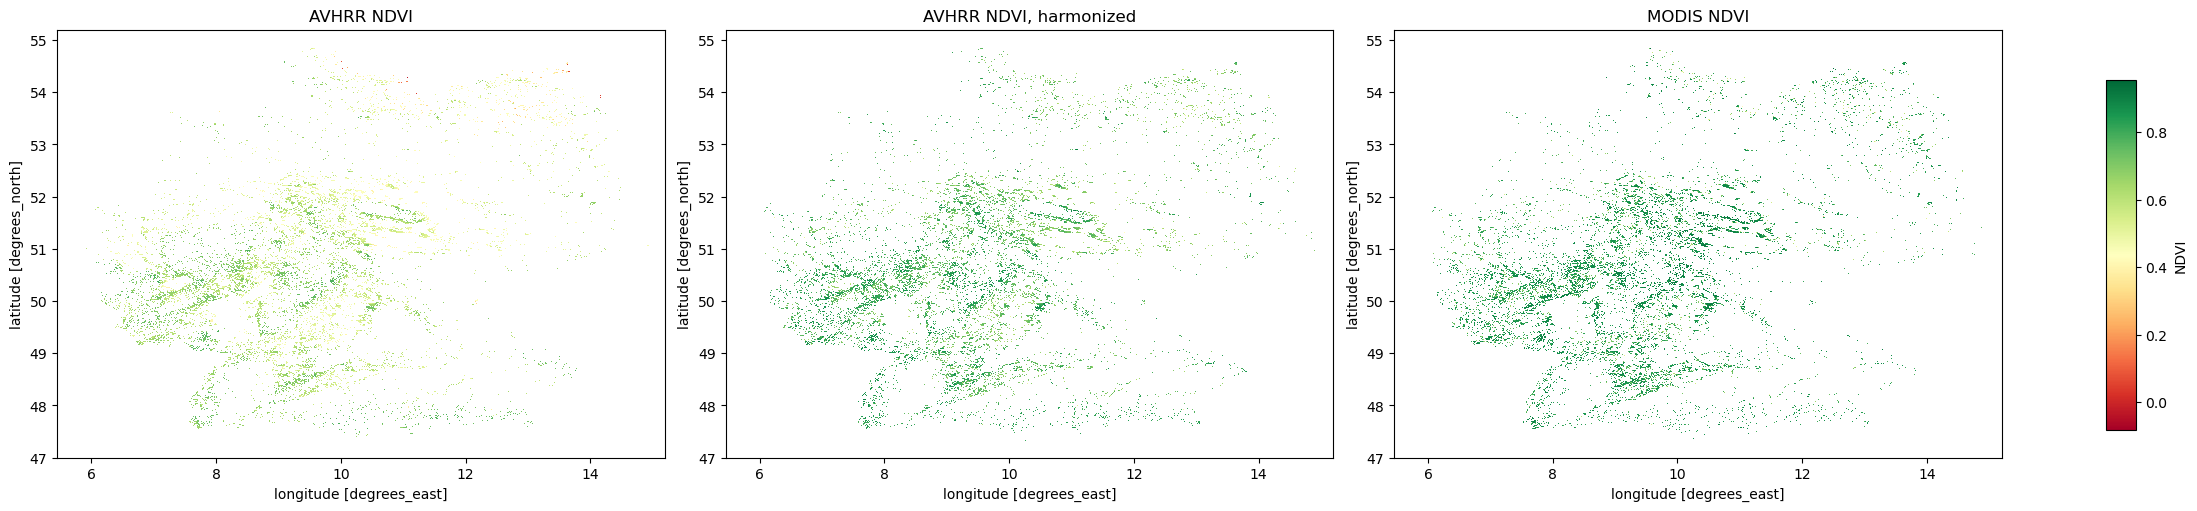

In [23]:
# plot an example
ndvi1 = ndvi_mon_avhrr_BL.NDVI.sel(time="2010-08-01")
ndvi2 = ndvi_mon_avhrr_BL_harm.NDVI.sel(time="2010-08-01")
ndvi3 = ndvi_mon_modis_BL.NDVI.sel(time="2010-08-01")

# get global min and max across the three datasets for one specific time to set up a shared legend
vmin = min(ndvi1.min().compute().item(),
           ndvi2.min().compute().item(),
           ndvi3.min().compute().item())

vmax = max(ndvi1.max().compute().item(),
           ndvi2.max().compute().item(),
           ndvi3.max().compute().item())

# create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5), constrained_layout = True)

# plot with shared color scale
im0 = ndvi_mon_avhrr_BL.NDVI.sel(time="2010-08-01").plot(ax=axs[0], cmap='RdYlGn', vmin=vmin, vmax=vmax, add_colorbar=False)
ndvi_mon_avhrr_BL_harm.NDVI.sel(time="2010-08-01").plot(ax=axs[1], cmap='RdYlGn', vmin=vmin, vmax=vmax, add_colorbar=False)
ndvi_mon_modis_BL.NDVI.sel(time="2010-08-01").plot(ax=axs[2], cmap='RdYlGn', vmin=vmin, vmax=vmax, add_colorbar=False)

axs[0].set_title("AVHRR NDVI")
axs[1].set_title("AVHRR NDVI, harmonized")
axs[2].set_title("MODIS NDVI")

# add one colorbar for all subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im0, cax=cbar_ax, orientation='vertical')
cbar.set_label("NDVI")

plt.show()

In [31]:
# calculate linear regression equations for the rest of the ndvi datasets
# first, monthly ndvi values of needleleaved forest
dir = "./NDVI/Monthly_AVHRR_Overlap"
filelist = glob.glob(os.path.join(dir, "*NL*.nc"))
ndvi_mon_avhrr_NL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

dir = "./NDVI/Monthly"
filelist = []
for year in range(2000, 2011):
    pattern = os.path.join(dir, f'*{year}_NL.nc')
    filelist.extend(glob.glob(pattern))
ndvi_mon_modis_NL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

# January 2000 not available in MODIS dataset -> drop this month in AVHRR dataset
date_to_drop = pd.Timestamp("2000-01-01")
ndvi_mon_avhrr_NL = ndvi_mon_avhrr_NL.sel(time=ndvi_mon_avhrr_NL.time != date_to_drop)

# apply function to calculate linear regression
regression_ds_ndvi_mon_NL = xr_regression(x = ndvi_mon_avhrr_NL.NDVI, y = ndvi_mon_modis_NL.NDVI)

# save dataset with regression values
regression_ds_ndvi_mon_NL.to_netcdf("./NDVI/regression_ds_ndvi_mon_NL.nc")

In [36]:
# now, calculate linear regression equations for yearly ndvi values of broadleaved forest
dir = "./NDVI/Yearly_AVHRR_Overlap"
filelist = glob.glob(os.path.join(dir, "*BL*.nc"))
ndvi_year_avhrr_BL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

dir = "./NDVI/Yearly"
filelist = []
for year in range(2000, 2011):
    pattern = os.path.join(dir, f'*{year}_BL.nc')
    filelist.extend(glob.glob(pattern))
ndvi_year_modis_BL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

# apply function to calculate linear regression
regression_ds_ndvi_year_BL = xr_regression(x = ndvi_year_avhrr_BL.NDVI, y = ndvi_year_modis_BL.NDVI)

# save dataset with regression values
regression_ds_ndvi_year_BL.to_netcdf("./NDVI/regression_ds_ndvi_year_BL.nc")

In [37]:
# and finally, calculate linear regression equations for yearly ndvi values of needleleaved forest
dir = "./NDVI/Yearly_AVHRR_Overlap"
filelist = glob.glob(os.path.join(dir, "*NL*.nc"))
ndvi_year_avhrr_NL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

dir = "./NDVI/Yearly"
filelist = []
for year in range(2000, 2011):
    pattern = os.path.join(dir, f'*{year}_NL.nc')
    filelist.extend(glob.glob(pattern))
ndvi_year_modis_NL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

# apply function to calculate linear regression
regression_ds_ndvi_year_NL = xr_regression(x = ndvi_year_avhrr_NL.NDVI, y = ndvi_year_modis_NL.NDVI)

# save dataset with regression values
regression_ds_ndvi_year_NL.to_netcdf("./NDVI/regression_ds_ndvi_year_NL.nc")

In [38]:
# now, apply linear regression to the original (1981 - 1999) AVHRR datasets to harmonize the timeline between AVHRR and MODIS data
# start with monthly BL and NL ndvi
# create list with forest types
forest_types = ("NL", "BL")
for f in range(len(forest_types)):
    forest_type = forest_types[f]

    # open according dataset with linear regression values
    regression_ds = xr.open_dataset(f"./NDVI/regression_ds_ndvi_mon_{forest_type}.nc", decode_coords = "all", decode_times = True)

    # open original avhrr monthly ndvi values for 1981 - 1999
    for year in range(1981, 2000):
        ndvi_original = xr.open_dataset(f"./NDVI/Monthly/ndvi_mon_mean_{year}_{forest_type}.nc", decode_coords = "all", decode_times = True)

        # apply linear regression to original ndvi dataset to harmonize data
        ndvi_harmonized = ndvi_original * regression_ds.slope + regression_ds.intercept

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        ndvi_harmonized.NDVI.encoding.update(comp)

        # save created datasets as netCDF4 files
        ndvi_harmonized.to_netcdf(f"./NDVI/Monthly_harmonized/NDVI_mon_mean_{year}_{forest_type}.nc")

In [39]:
# continue with yearly BL and NL ndvi
# create list with forest types
forest_types = ("NL", "BL")
for f in range(len(forest_types)):
    forest_type = forest_types[f]

    # open according dataset with linear regression values
    regression_ds = xr.open_dataset(f"./NDVI/regression_ds_ndvi_year_{forest_type}.nc", decode_coords = "all", decode_times = True)

    # open original avhrr yearly ndvi values for 1981 - 1999
    for year in range(1981, 2000):
        ndvi_original = xr.open_dataset(f"./NDVI/Yearly/ndvi_year_mean_{year}_{forest_type}.nc", decode_coords = "all", decode_times = True)

        # apply linear regression to original ndvi dataset to harmonize data
        ndvi_harmonized = ndvi_original * regression_ds.slope + regression_ds.intercept

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        ndvi_harmonized.NDVI.encoding.update(comp)

        # save created datasets as netCDF4 files
        ndvi_harmonized.to_netcdf(f"./NDVI/Yearly_harmonized/NDVI_year_mean_{year}_{forest_type}.nc")

In [43]:
# now, spatially aggregate the harmonized timelines to get mean values for Germany and the federal states
# first, get values for broadleaved forest
# load all yearly ndvi values as one dataset
directory = f"./NDVI/Yearly_harmonized"
filelist = glob.glob(os.path.join(directory, "*BL*.nc"))
ndvi_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

# calculate mean ndvi values per year for Germany
ndvi_yearly_spatial_means = ndvi_yearly.mean(['lon','lat'], skipna=True).to_dataframe()

# drop unneeded columns
ndvi_yearly_spatial_means = ndvi_yearly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

# rename column with NDVI value to show area
ndvi_yearly_spatial_means.rename({"NDVI":"GER"}, axis=1, inplace=True)

In [44]:
# now, calculate yearly mean ndvi values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    ndvi_ex = ndvi_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=ndvi_ex.odc.geobox.shape,
                                                transform=ndvi_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly ndvi data
    ndvi_state = ndvi_yearly["NDVI"].where(~state_mask)

    # calculate yearly mean ndvi of state and extract to dataframe
    ndvi_state_spatial_means = ndvi_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    ndvi_state_spatial_means = ndvi_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add yearly mean ndvi values of state to dataframe
    ndvi_yearly_spatial_means[state] = ndvi_state_spatial_means["NDVI"]   

In [45]:
ndvi_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,0.693265,0.684491,0.658810,0.694432,0.702173,0.667908,0.707925,0.654943,0.691516,0.683111,0.684442,0.707726,0.684163,0.686954,0.622668,0.649403,0.680813
1982-01-01,0.686368,0.668440,0.653715,0.684822,0.693807,0.658271,0.704413,0.656638,0.688497,0.680315,0.679797,0.705993,0.696051,0.680364,0.598636,0.627310,0.657433
1983-01-01,0.692643,0.685958,0.663181,0.687298,0.696633,0.666261,0.708707,0.666831,0.696271,0.685912,0.686116,0.707698,0.699479,0.680429,0.622818,0.655607,0.676730
1984-01-01,0.692521,0.670508,0.652997,0.694380,0.699934,0.638406,0.709378,0.657325,0.685222,0.679573,0.688656,0.709422,0.687806,0.683439,0.619955,0.645568,0.679495
1985-01-01,0.701514,0.689902,0.662706,0.696211,0.705697,0.686625,0.714595,0.687444,0.708437,0.695382,0.698069,0.713023,0.714502,0.689497,0.643056,0.668933,0.687175
1986-01-01,0.701170,0.687054,0.660371,0.700858,0.699353,0.685994,0.716866,0.678747,0.703867,0.699159,0.702411,0.712828,0.706730,0.693792,0.621736,0.658355,0.684013
1987-01-01,0.703617,0.684112,0.661273,0.699586,0.707412,0.685053,0.715769,0.664809,0.703086,0.702095,0.696622,0.715176,0.696400,0.697220,0.635264,0.679637,0.702132
1988-01-01,0.695536,0.672433,0.658401,0.697596,0.702522,0.663181,0.713519,0.656683,0.681175,0.689491,0.689801,0.710840,0.686722,0.691124,0.619232,0.649321,0.683674
1989-01-01,0.692698,0.679047,0.653528,0.683671,0.695732,0.666427,0.710602,0.677062,0.697562,0.689476,0.688746,0.710873,0.710030,0.685396,0.606433,0.647770,0.671507


In [46]:
# save as csv dataset
ndvi_yearly_spatial_means.to_csv("./Tables/Spatial_Means/NDVI_Yearly_Spatial_Means_BL_harmonized.csv")

In [47]:
# now take the same steps for needleleaved forest
# load all yearly ndvi values as one dataset
directory = f"./NDVI/Yearly_harmonized"
filelist = glob.glob(os.path.join(directory, "*NL*.nc"))
ndvi_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

# calculate mean ndvi values per year for Germany
ndvi_yearly_spatial_means = ndvi_yearly.mean(['lon','lat'], skipna=True).to_dataframe()

# drop unneeded columns
ndvi_yearly_spatial_means = ndvi_yearly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

# rename column with NDVI value to show area
ndvi_yearly_spatial_means.rename({"NDVI":"GER"}, axis=1, inplace=True)

In [48]:
# now, calculate yearly mean ndvi values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    ndvi_ex = ndvi_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=ndvi_ex.odc.geobox.shape,
                                                transform=ndvi_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly ndvi data
    ndvi_state = ndvi_yearly["NDVI"].where(~state_mask)

    # calculate yearly mean ndvi of state and extract to dataframe
    ndvi_state_spatial_means = ndvi_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    ndvi_state_spatial_means = ndvi_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add yearly mean ndvi values of state to dataframe
    ndvi_yearly_spatial_means[state] = ndvi_state_spatial_means["NDVI"]   

In [49]:
ndvi_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,0.706776,0.680531,0.648606,0.749488,0.711536,0.613979,0.730200,0.624488,0.706627,0.703495,0.717561,0.738462,0.691388,0.702369,0.687755,0.684284,0.712555
1982-01-01,0.698802,0.667031,0.644964,0.743396,0.702819,0.613353,0.728904,0.656950,0.702954,0.701639,0.714567,0.742327,0.697354,0.698519,0.669075,0.671734,0.704429
1983-01-01,0.705714,0.683614,0.652348,0.743368,0.704847,0.608208,0.730172,0.644937,0.710781,0.706549,0.718903,0.742556,0.702711,0.700448,0.681965,0.686750,0.712436
1984-01-01,0.703366,0.670227,0.644537,0.747185,0.709285,0.593360,0.730660,0.665880,0.702175,0.699645,0.721488,0.741758,0.691539,0.699469,0.680048,0.675093,0.718935
1985-01-01,0.710615,0.684228,0.649900,0.746326,0.711521,0.616101,0.730698,0.670085,0.714952,0.712309,0.725381,0.742245,0.713816,0.705086,0.692472,0.693161,0.719260
1986-01-01,0.709306,0.684363,0.650656,0.750009,0.706857,0.616951,0.730837,0.643211,0.714752,0.716064,0.726838,0.742487,0.704452,0.706260,0.681093,0.692186,0.717090
1987-01-01,0.710444,0.681301,0.651337,0.748270,0.713513,0.619310,0.732183,0.680891,0.710862,0.711828,0.719768,0.741405,0.697538,0.707587,0.687975,0.694490,0.728860
1988-01-01,0.705161,0.673894,0.645936,0.749041,0.709798,0.601223,0.730863,0.687915,0.701732,0.703044,0.722133,0.741858,0.691112,0.704456,0.681835,0.678191,0.720923
1989-01-01,0.703617,0.674441,0.645196,0.742676,0.705615,0.616447,0.730852,0.636585,0.707763,0.707284,0.718634,0.741860,0.708311,0.702445,0.679168,0.680344,0.712035


In [50]:
# save as csv dataset
ndvi_yearly_spatial_means.to_csv("./Tables/Spatial_Means/NDVI_Yearly_Spatial_Means_NL_harmonized.csv")